<a href="https://colab.research.google.com/github/gyeongee/TIL/blob/main/LeNet_5%EA%B5%AC%ED%98%84_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

예시가 보편적인 구현 방법인듯, 모델마다 층만 다르고 기본 세팅은 같

### 1. 모듈 가져오기

In [ ]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
from pytz import timezone

### 2. Hyperparameters

In [ ]:
Random_seed = 42 #그냥 정하는 것
Learning_rate = 0.001 # 학습률
Batch_size = 64 # batch size. 이 단위로 학습이 된다.
N_epochs = 15 # epoch 횟수 전체 데이터가 15번 학습된다는 뜻.
Img_size = 28 # 32*32 이미지가 들어갈 것이다.
N_classes = 10 # 0~9 10개의 output class가 있다.

### 3. get_accuaracy 함수(모델의 정확도 측정)

In [ ]:
def get_accuracy(model, data_loader, device) :
  correct_pred = 0
  n = 0
  with torch.no_grad() :
    model.eval() #batch nomalization, drop out과 같은거 없이! 모델이 평가모드로 전환
    for X, y_true in data_loader : #데이터 셋에 있는 인풋
      X = X.to(device)
      y_true = y_true.to(device)
      _, y_prob = model(X) #y_prob은 후에 나올 LeNet-5 모델에서 소프트맥스 함수를 통과한 클래스 확률
      _, predicted_labels = torch.max(y_prob,1) #torch.max(y_prob,1) = 열 중에서 가장 높은 값을 뽑아준다. 그럼 그게 예측 라벨이 되겠죠?

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()
  return correct_pred.float() / n # 정확히 맞춘것 / 총 개수

### 4. 손실 plotting 함수

In [ ]:
def plot_loss(train_loss, val_loss) :
  plt.style.use('grayscale')
  train_loss = np.array(train_loss)
  val_loss = np.array(val_loss)
  fig , ax = plt.subplots(1,1,figsize = (8,4.5))
  ax.plot(train_loss, color = 'green' , label = 'Training Loss')
  ax.plot(val_loss, color = 'red' , label = 'Validation Loss')
  ax.set(title = 'Loss Over Epochs' , xlabel = 'EPOCH' , ylabel = 'LOSS')
  ax.legend()
  fig.show()
  plt.style.use('default')

### 5. Train 함수

In [ ]:
def train(train_loader, model, criterion, optimizer, device) :
  model.train() #모델을 학습 모드로 설정
  running_loss = 0 # 초기값 0으로 설정
  for X, y_true in train_loader:
    optimizer.zero_grad() #역전파시 효과적으로 학습되기 위해 설정 매번 세팅되어야함
    X = X.to(device)
    y_true = y_true.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat,y_true) #loss를 구함
    running_loss += loss.item() * X.size(0) #사이즈를 곱해줘서 전체적인 running loss를 구함
    loss.backward() #역전파
    optimizer.step() #Gradient descent
  epoch_loss = running_loss / len(train_loader.dataset)
  return model , optimizer, epoch_loss

### 6. Validate 함수

In [ ]:
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        # 순전파와 손실 기록하기
        y_hat, _ = model(X) #소프트 맥스 당하기 전 !
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

### 7. Traing_loop 함수

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):

    # metrics를 저장하기 위한 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # model 학습하기
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(datetime.now(timezone('Asia/Seoul')).time().replace(microsecond=0),'--- ',
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), #Bias default
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # ddefault stride = kernel_size
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        ) # 120개의 input data를 받아 84개의 output을 배출하고, activation function을 통과한 뒤 84개의 input data를 받아, 10개의 클래스를 output으로


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) # 1차원으로 쫙펴준다
        logits = self.classifier(x) # classifier에 통과시켜준다
        probs = F.softmax(logits, dim=1) # 나온 10개의 값들을 softmax로 확률 구해준다.
        return logits, probs

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


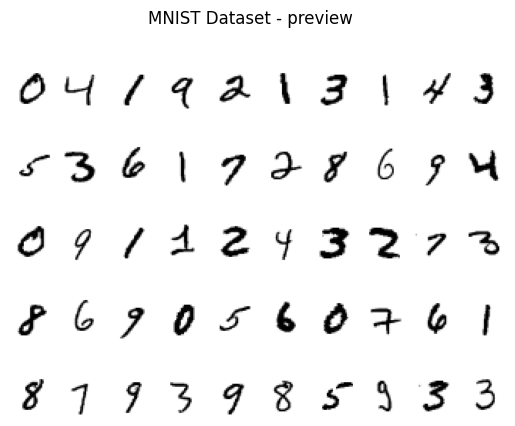

In [ ]:
# transforms 정의하기
# 이미지 사이즈 32x32
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# data set 다운받고 생성하기
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

# data loader 정의하기
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=Batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=Batch_size,
                          shuffle=False)

# 불러온 MNIS data 확인하기
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

19:52:47 ---  Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
19:53:17 ---  Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
19:53:46 ---  Epoch: 2	Train loss: 0.0550	Valid loss: 0.0543	Train accuracy: 98.59	Valid accuracy: 98.45
19:54:14 ---  Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.43
19:54:43 ---  Epoch: 4	Train loss: 0.0344	Valid loss: 0.0415	Train accuracy: 99.21	Valid accuracy: 98.71
19:55:11 ---  Epoch: 5	Train loss: 0.0296	Valid loss: 0.0411	Train accuracy: 99.42	Valid accuracy: 98.78
19:55:39 ---  Epoch: 6	Train loss: 0.0242	Valid loss: 0.0450	Train accuracy: 99.49	Valid accuracy: 98.62
19:56:08 ---  Epoch: 7	Train loss: 0.0223	Valid loss: 0.0443	Train accuracy: 99.51	Valid accuracy: 98.68
19:56:36 ---  Epoch: 8	Train loss: 0.0190	Valid loss: 0.0448	Train accuracy: 99.50	Valid accuracy: 98.73
19:57:05 ---  Epoch: 9	Train loss: 0.0162	Valid loss: 0

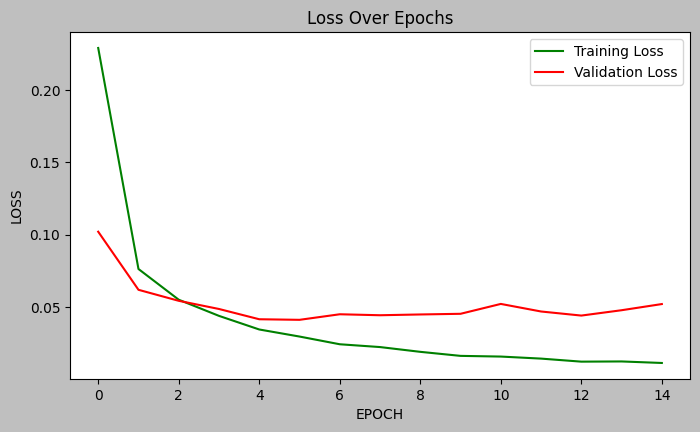

In [ ]:
torch.manual_seed(Random_seed)

model = LeNet5(N_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_rate)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader,
                                    valid_loader, N_epochs, DEVICE)